In [68]:
import math
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

from sklearn.metrics import r2_score, mean_squared_error



In [69]:
# x_train = features, y_train = target

df = pd.read_csv('18-pci-final-cleaned.csv')


x = df.drop('PCI',axis=1)
y = df.PCI


# Seed value
# Apparently you may use different seed values at each stage
seed_value= 33

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# import keras.backend.tensorflow_backend as K
# session_conf =  tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=seed_value)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8889, random_state=seed_value)

In [70]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled
  return x_train, x_test
x_train_scaled, x_test_scaled = scale_datasets(x_train, x_test)
_ , x_val_scaled = scale_datasets(x_train, x_val)

x_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 18 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AC1     400 non-null    float64
 1   AC2     400 non-null    float64
 2   AC3     400 non-null    float64
 3   BE1     400 non-null    float64
 4   BE2     400 non-null    float64
 5   BE3     400 non-null    float64
 6   D1      400 non-null    float64
 7   D2      400 non-null    float64
 8   D3      400 non-null    float64
 9   F1      400 non-null    float64
 10  F2      400 non-null    float64
 11  F3      400 non-null    float64
 12  G1      400 non-null    float64
 13  G2      400 non-null    float64
 14  G3      400 non-null    float64
 15  H1      400 non-null    float64
 16  H2      400 non-null    float64
 17  H3      400 non-null    float64
dtypes: float64(18)
memory usage: 56.4 KB


In [71]:
hidden_units1 = 12
# hidden_units2 = 12
# hidden_units3 = 12
# hidden_units1 = 160
# hidden_units2 = 480
# hidden_units3 = 256
learning_rate = 0.01
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
  model = Sequential([
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    # Dropout(0.2),
    # Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal', activation='relu')
  ])
  return model
# build the model
model = build_model_using_sequential()

In [72]:
# import tensorflow as tf
# from tensorflow.keras.metrics import Metric
# from tensorflow.keras import backend as K

# class R2KerasMetric(Metric):
#     def __init__(self, name='r2_keras', **kwargs):
#         super(R2KerasMetric, self).__init__(name=name, **kwargs)
#         self.r2_values = self.add_weight(name='r2_values', initializer='zeros')
#         self.total_samples = self.add_weight(name='total_samples', initializer='zeros')

#     def update_state(self, y_true, y_pred, sample_weight=None):
#         y_true_flat = tf.reshape(y_true, shape=(-1,))
#         y_pred_flat = tf.reshape(y_pred, shape=(-1,))
#         residual = y_true_flat - y_pred_flat
#         ss_res = K.sum(K.square(residual))
#         ss_tot = K.sum(K.square(y_true_flat - K.mean(y_true_flat)))
#         r2 = 1 - ss_res / (ss_tot + K.epsilon())
#         current_samples = tf.cast(tf.size(y_true), dtype=tf.float32)
#         self.r2_values.assign_add(r2 * current_samples)
#         self.total_samples.assign_add(current_samples)

#     def result(self):
#         return self.r2_values / self.total_samples

#     def reset_states(self):
#         self.r2_values.assign(0.0)
#         self.total_samples.assign(0.0)

#     # Add the variables property as required by Keras
#     @property
#     def variables(self):
#         return self._collected_trainable_weights

#     # Override the get_config method to avoid issues with serialization
#     def get_config(self):
#         return {}

In [73]:
# def r2_keras(y_true, y_pred):
#     r2 = r2_score(y_true, y_pred)
#     return tf.convert_to_tensor(r2, dtype=tf.float32)  # Convert the result to a tensor


# loss function
msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=['mse' ]
)


In [74]:
# train the model
history = model.fit(
    x_train_scaled.values, 
    y_train.values, 
    epochs=200, 
    batch_size=32,
    # validation_split=0.2
    validation_data=(x_val_scaled, y_val)
)

Epoch 1/200
13/13 [==============================] - 1s 24ms/step - loss: 3919.8625 - mse: 3919.8625 - val_loss: 3514.6318 - val_mse: 3514.6318
Epoch 2/200
13/13 [==============================] - 0s 6ms/step - loss: 3806.6946 - mse: 3806.6946 - val_loss: 3339.9282 - val_mse: 3339.9282
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 3536.0540 - mse: 3536.0540 - val_loss: 3016.1853 - val_mse: 3016.1853
Epoch 4/200
13/13 [==============================] - 0s 6ms/step - loss: 3087.6169 - mse: 3087.6169 - val_loss: 2533.6318 - val_mse: 2533.6318
Epoch 5/200
13/13 [==============================] - 0s 6ms/step - loss: 2486.3416 - mse: 2486.3416 - val_loss: 1956.1957 - val_mse: 1956.1957
Epoch 6/200
13/13 [==============================] - 0s 5ms/step - loss: 1816.0697 - mse: 1816.0697 - val_loss: 1399.0916 - val_mse: 1399.0916
Epoch 7/200
13/13 [==============================] - 0s 5ms/step - loss: 1232.5520 - mse: 1232.5520 - val_loss: 958.7609 - val_mse: 958.7609


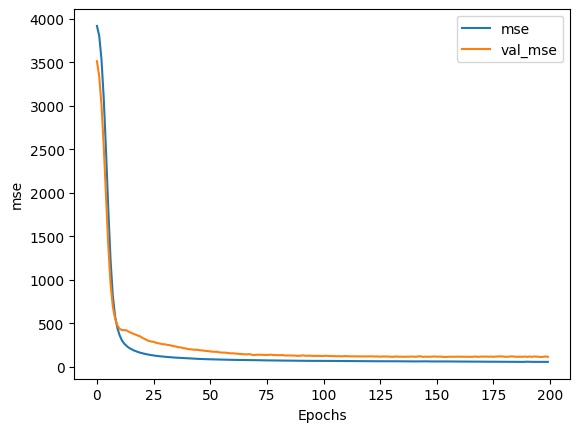

In [75]:
def plot_history(history, key):
  plt.plot(history.history[key])
  plt.plot(history.history['val_'+key])
  plt.xlabel("Epochs")
  plt.ylabel(key)
  plt.legend([key, 'val_'+key])
  plt.show()
# Plot the history
plot_history(history, 'mse')


In [76]:
x_test_prediction = model.predict(x_test_scaled)
x_train_prediction = model.predict(x_train_scaled)
x_val_prediction = model.predict(x_val_scaled)

model.evaluate(x_test_scaled,y_test)

2/2 [==============================] - 0s 5ms/step - loss: 103.4574 - mse: 103.4574


[103.4574203491211, 103.4574203491211]

In [77]:

test_mse = model.evaluate(x_test_scaled,y_test)[0]

import numpy as np

test_r2 = 1- test_mse / np.var(y)
train_r2 = 1 - (history.history['mse'][-1]) / np.var(y)
# val_r2 = 1 - 
validation_r2 = 1 - (history.history['val_mse'][-1] / np.var(y))
print(f"test_r2 = {test_r2}")
print(f"train_r2 = {train_r2}")
print(f"validation_r2 = {validation_r2}")
# old
# 1/1 [==============================] - 0s 34ms/step - loss: 183.8063 - mse: 183.8063
# test_r2 = 0.606630144702222
# train_r2 = 0.7078877539895123
# validation_r2 = 0.5623892620021058

2/2 [==============================] - 0s 6ms/step - loss: 103.4574 - mse: 103.4574
test_r2 = 0.7470401754434282
train_r2 = 0.857208645438057
validation_r2 = 0.7152936159912746


line: y = 0.8564043824475055 * x + 6.612349553343698


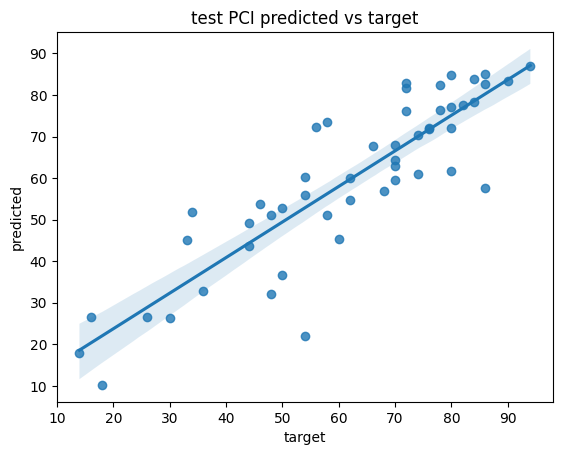

In [60]:
import seaborn as sns
ax = sns.regplot(x=y_test ,y= x_test_prediction,)
ax.set(title = 'test PCI predicted vs target', xlabel='target', ylabel='predicted')
#calculate slope and intercept of regression equation
import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")


line: y = 0.853406695058406 * x + 8.589786263191826


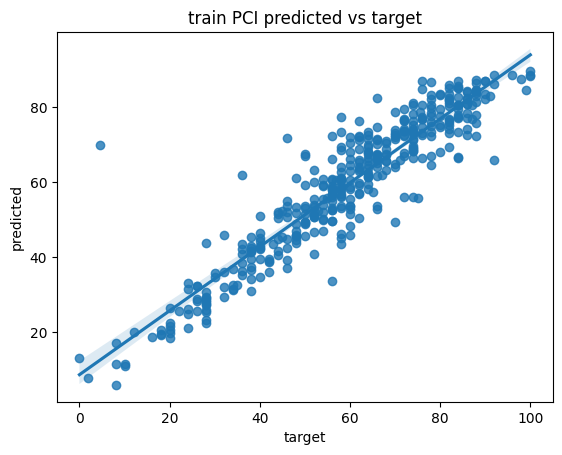

In [61]:
ax = sns.regplot(x=y_train, y= x_train_prediction)
ax.set(title = 'train PCI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")



line: y = 0.8649602894054312 * x + 7.114003622258181


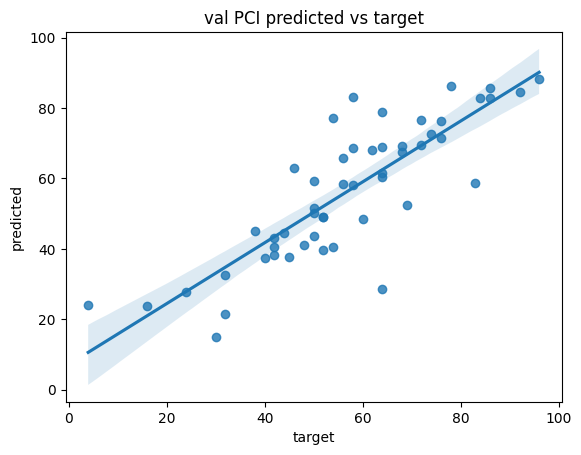

In [78]:
ax = sns.regplot(x=y_val, y= x_val_prediction)
ax.set(title = 'val PCI predicted vs target', xlabel='target', ylabel='predicted')

import scipy
slope, intercept, r, p, sterr = scipy.stats.linregress(x=ax.get_lines()[0].get_xdata(),
                                                       y=ax.get_lines()[0].get_ydata())

print(f"line: y = {slope} * x + {intercept}")



In [62]:
z = pd.DataFrame({'AC1': [0.0],
                  'AC2': [0.0],
                  'AC3': [1.2],
                  'BE1': [0.0],
                  'BE2': [0.78],
                  'BE3': [0.11],
                  'D1': [0.0],
                  'D2': [0.0],
                  'D3': [0.2],
                  'F1': [0.0],
                  'F2': [0.2],
                  'F3': [0.0],
                  'G1': [0.0],
                  'G2': [0.0],
                  'G3': [0.33],
                  'H1': [0.0],
                  'H2': [0.0],
                  'H3': [0.32]})
# model.predict()
z = pd.DataFrame(z)
_, z = scale_datasets(x_train, z)

model.predict(z)


1/1 [==============================] - 0s 29ms/step


array([[32.538044]], dtype=float32)